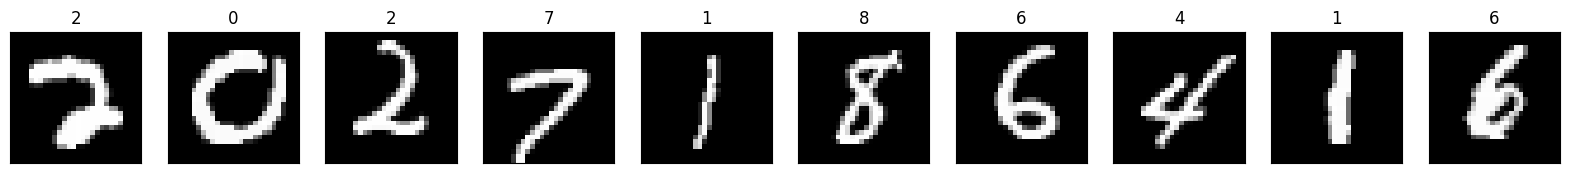

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 189.1405

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 47s 783us/sample - loss: 189.1405 - val_loss: 174.3704
Epoch 2/20
60000/60000 [==============================] - 47s 779us/sample - loss: 173.0626 - val_loss: 172.2551
Epoch 3/20
60000/60000 [==============================] - 46s 775us/sample - loss: 170.9748 - val_loss: 169.9409
Epoch 4/20
60000/60000 [==============================] - 45s 757us/sample - loss: 168.0210 - val_loss: 166.4591
Epoch 5/20
60000/60000 [==============================] - 47s 778us/sample - loss: 165.7685 - val_loss: 164.9878
Epoch 6/20
60000/60000 [==============================] - 47s 784us/sample - loss: 164.5913 - val_loss: 164.0817
Epoch 7/20
60000/60000 [==============================] - 45s 754us/sample - loss: 163.8982 - val_loss: 163.5937
Epoch 8/20
60000/60000 [==============================] - 46s 774us/sample - loss: 163.3731 - val_loss: 163.0878
Epoch 9/20
60000/60000 [==============================] - 45s 756us/sample - loss: 162.9436 - val_loss: 162

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


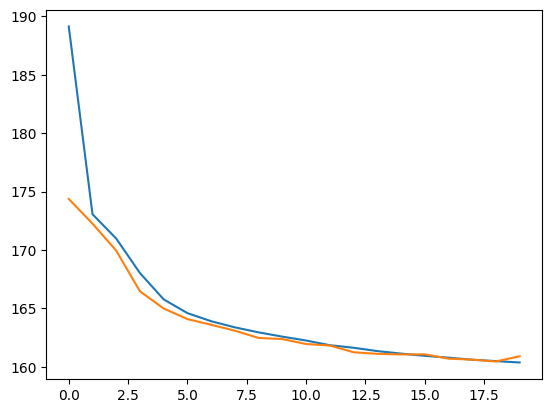

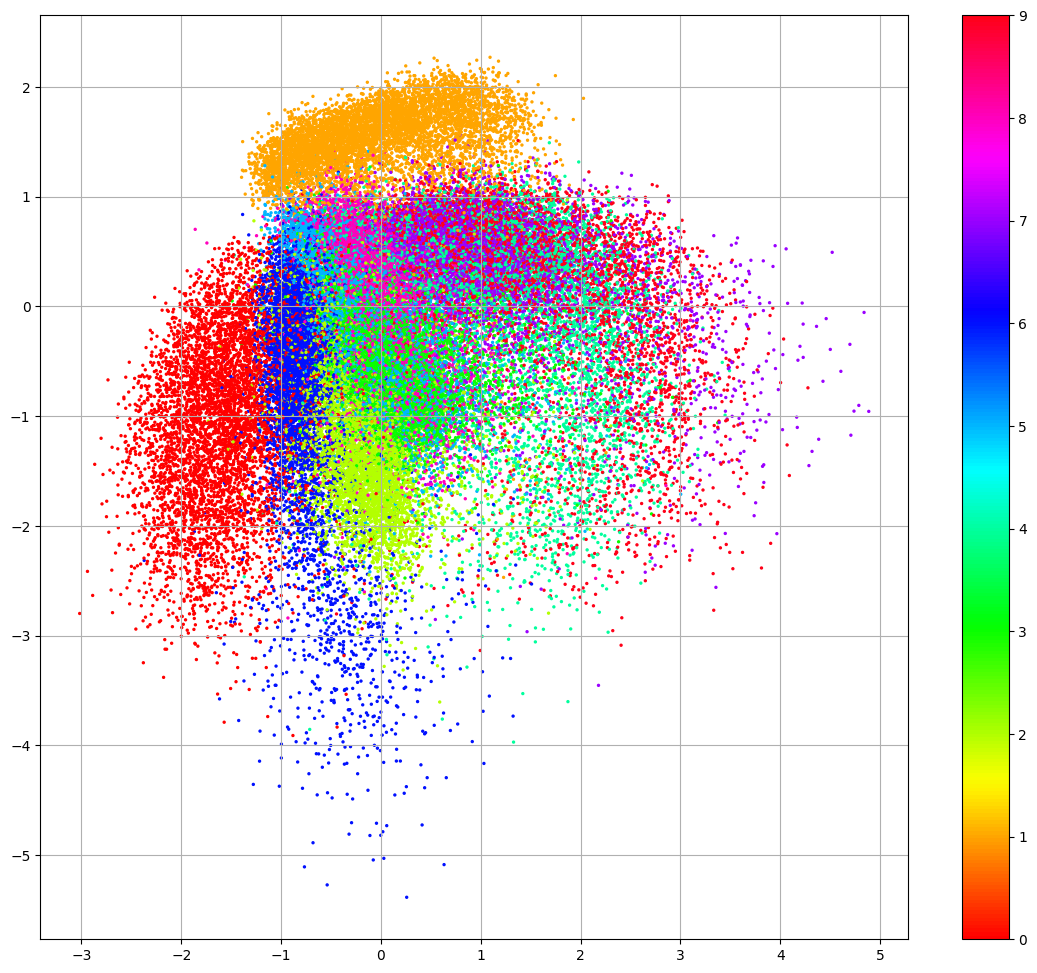

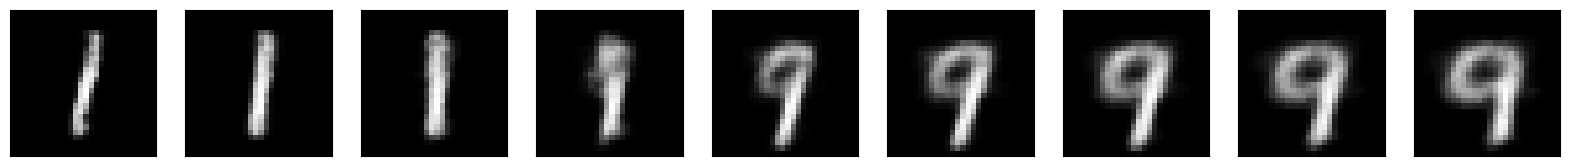

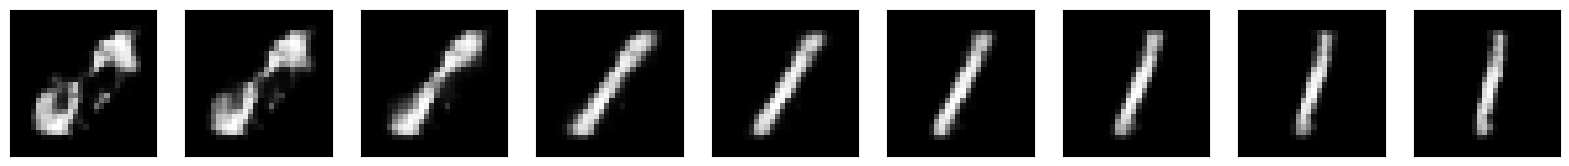

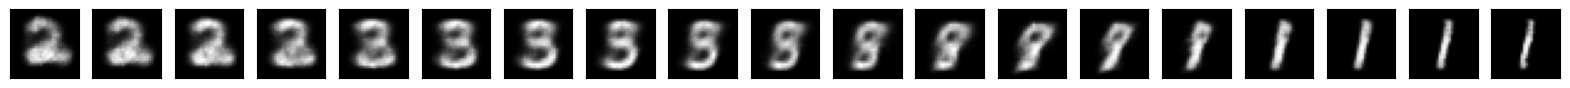

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()

# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)

    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]

    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])

    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

# Normalize values such that all numbers are within
# the range of 0 to 1
X_train = X_train/255
X_test = X_test/255

# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space


# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2,
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2,
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3,
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=20, batch_size=32, validation_data=(X_test_new,X_test_new))

# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()

# Displaying several new images
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-2,1,0,2,9)

# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)
